# **Supermarket sales: This dataset can be used for predictive data analytics purpose.**

In essence, feature engineering entails the task of directing or focusing the model's attention on certain information deemed important by the data scientist, as opposed to generating completely novel information.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import lightgbm as lgb
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
sales = pd.read_csv('supermarket_sales.csv')
sales.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


# **Numeric aggregations**

In [3]:
grouped_sales = sales.groupby('Branch')
sales[['tax_branch_mean','unit_price_mean']] = grouped_sales[['Tax 5%', 'Unit price']].transform('mean')
sales[['tax_branch_std','unit_price_std']] = grouped_sales[['Tax 5%', 'Unit price']].transform('std')
sales[['product_count','gender_count']] = grouped_sales[['Product line', 'Gender']].transform('count')
sales[['Branch', 'tax_branch_mean', 'unit_price_mean', 'tax_branch_std', 'unit_price_std', 'product_count', 'gender_count']].head(10)

,Branch,tax_branch_mean,unit_price_mean,tax_branch_std,unit_price_std,product_count,gender_count
0,A,14.874001,54.780853,11.030477,26.132127,340,340
1,C,16.052367,56.609024,12.531470,27.179799,328,328
2,A,14.874001,54.780853,11.030477,26.132127,340,340
3,A,14.874001,54.780853,11.030477,26.132127,340,340
4,A,14.874001,54.780853,11.030477,26.132127,340,340
5,C,16.052367,56.609024,12.531470,27.179799,328,328
6,A,14.874001,54.780853,11.030477,26.132127,340,340
7,C,16.052367,56.609024,12.531470,27.179799,328,328
8,A,14.874001,54.780853,11.030477,26.132127,340,340
9,B,15.232024,55.659277,11.545122,26.224559,332,332


# **Indicator Variables and Interaction Terms**

In [4]:
sales['unit_price_50'] = np.where(sales['Unit price'] > 50, 1, 0)
sales['unit_price_50 * qty'] = sales['unit_price_50'] * sales['Quantity']
sales[['unit_price_50', 'unit_price_50 * qty']].head()

,unit_price_50,unit_price_50 * qty
0,1,7
1,0,0
2,0,0
3,1,8
4,1,7


# **Numeric Transformations**

A novel variable, denoted as log_cogs, was developed for the purpose of rectifying the positive skewness in the cogs variable.

In [5]:
sales['log_cogs'] = np.log(sales['cogs'] + 1)
sales['gross income squared'] = np.square(sales['gross income'])
sales[['cogs', 'log_cogs', 'gross income', 'gross income squared']].head()

,cogs,log_cogs,gross income,gross income squared
0,522.83,6.261167,26.1415,683.378022
1,76.40,4.348987,3.8200,14.592400
2,324.31,5.784779,16.2155,262.942440
3,465.76,6.145815,23.2880,542.330944
4,604.17,6.405509,30.2085,912.553472


In [6]:
def plot_hist(data1, data2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    sns.histplot(data1, ax=ax1, kde=True)
    sns.histplot(data2, ax=ax2, kde=True);

Evidently, the application of a logarithmic transformation has rendered the distribution of Cost of Goods Sold (COGS) to be more indicative of a normal distribution, thereby reducing its rightward skewness. The aforementioned advantage is afforded to models such as linear regression, in which their weights or coefficients are less susceptible to being heavily impacted by outliers, which may have been the impetus for the aforementioned distortion.

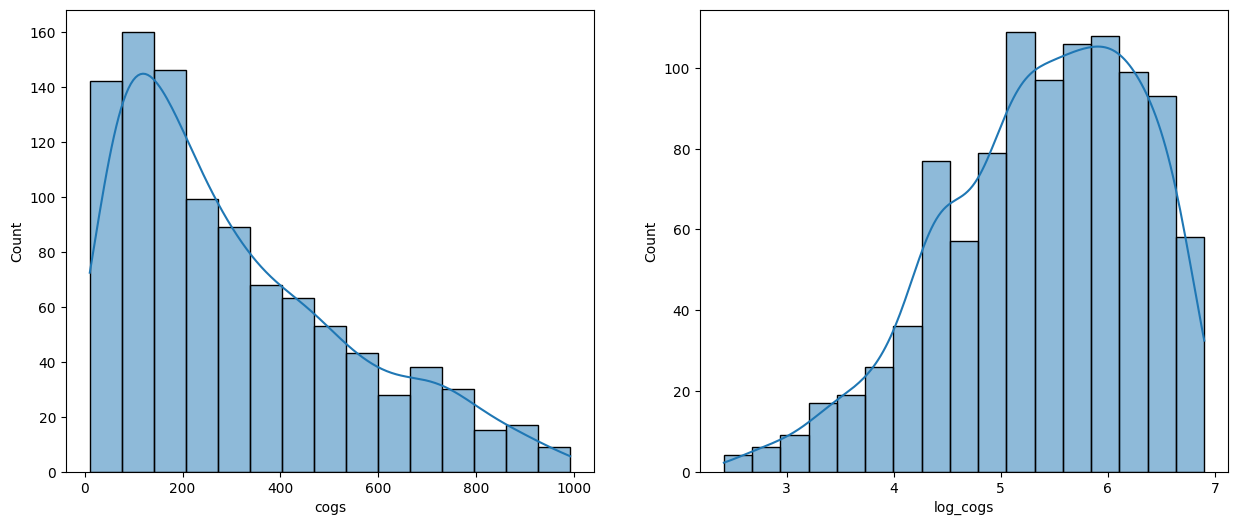

In [7]:
plot_hist(sales['cogs'],sales['log_cogs'])

# **Numeric Scaling**

Gross income range: 0.5085 to 49.65
Rating range: 4.0 to 10.0


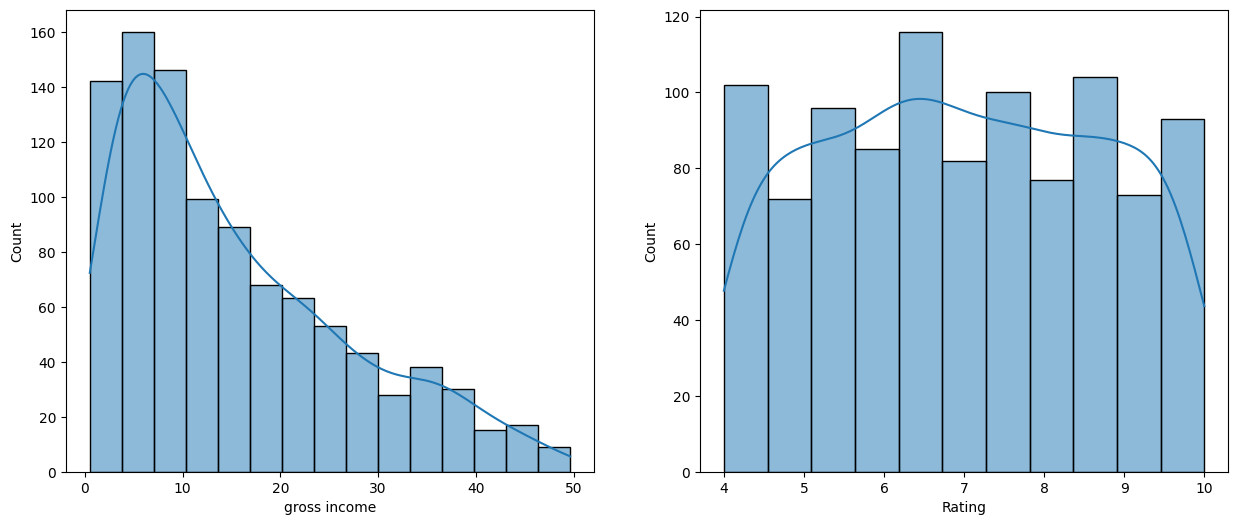

In [8]:
gincome, rating = sales["gross income"], sales["Rating"]
print(f'Gross income range: {gincome.min()} to {gincome.max()}')
print(f'Rating range: {rating.min()} to {rating.max()}')
plot_hist(gincome, rating)

We can see the difference in scale after applying normalization below.

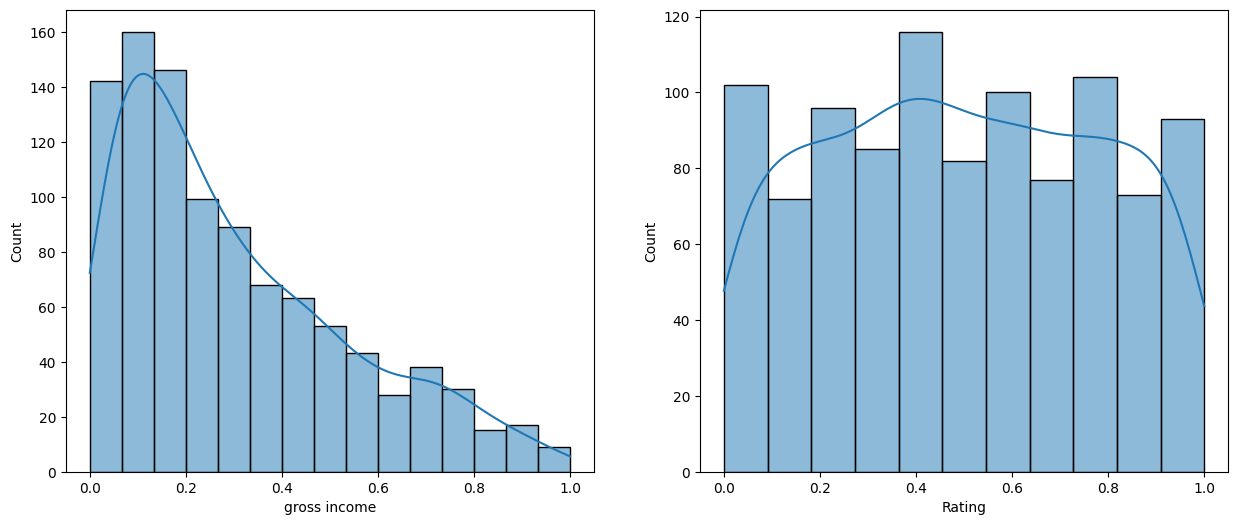

In [9]:
sales[["gross income", "Rating"]] = MinMaxScaler().fit_transform(sales[["gross income", "Rating"]])
plot_hist(sales['gross income'], sales['Rating'])

# **Categorical Variable Handling**

**One-hot encoding**

In [10]:
pd.get_dummies(sales[['Gender','Payment']]).head()

,Gender_Female,Gender_Male,Payment_Cash,Payment_Credit card,Payment_Ewallet
0,1,0,0,0,1
1,1,0,1,0,0
2,0,1,0,1,0
3,0,1,0,0,1
4,0,1,0,0,1


**Target encoding**

The process of target encoding does not result in the generation of supplementary columns. The concept is straightforward in that for each distinct category, the mean value of the dependent variable, given that it is continuous or binary, is computed and adopted as the value representing the corresponding category within the categorical column.

In [11]:
means = sales.groupby('Product line')['Rating'].mean()
sales['Product line target encoded'] = sales['Product line'].map(means)
sales[['Product line','Product line target encoded','Rating']]

,Product line,Product line target encoded,Rating
0,Health and beauty,0.500548,0.850000
1,Electronic accessories,0.487451,0.933333
2,Home and lifestyle,0.472917,0.566667
3,Health and beauty,0.500548,0.733333
4,Sports and travel,0.486044,0.216667
...,...,...,...
995,Health and beauty,0.500548,0.366667
996,Home and lifestyle,0.472917,0.066667
997,Food and beverages,0.518870,0.616667
998,Home and lifestyle,0.472917,0.016667


One drawback of target encoding entails that in instances where a grouping is represented only once, the associated mean value corresponds to the individual value, as the requisite mean of a sole number is equivalent to that number itself. Typically, it is not advisable to place undue reliance upon a mean or average when the quantity of values contributing to said mean or average is limited. One potential issue that arises pertains to the generalizability of outcomes from the training data set to the testing data set, or to the data that the model has not undergone training on.

The key point to be taken from this section is that one-hot-encoding should be considered if it won't present issues related to dimensionality. Should the matter arise, alternative approaches such as target encoding may be utilized.

# **Date-Time Decomposition**

Date-time decomposition involves the dissection of a given date variable into its individual components. This process is characterized by the identification and separation of the respective constituent elements that comprise a specific date. This is carried out in consideration of the model's requirement to effectively operate with numerical variables.

In [12]:
# Convert to datetime object
sales['Date'] = pd.to_datetime(sales['Date'])
sales[['Date']].head()

,Date
0,2019-01-05
1,2019-03-08
2,2019-03-03
3,2019-01-27
4,2019-02-08


In [13]:
# Decomposition
sales['Year'] = sales['Date'].dt.year
sales['Month'] = sales['Date'].dt.month
sales['Day'] = sales['Date'].dt.day
sales[['Year','Month','Day']].head()

,Year,Month,Day
0,2019,1,5
1,2019,3,8
2,2019,3,3
3,2019,1,27
4,2019,2,8


The present action entails the dissection of the date column, which originally presented itself in the configuration "year-month-day", into distinct columns comprising the year, month, and day. The aforementioned data can be leveraged by the model for prognostication purposes, given the quantitatively expressed nature of the recently appended columns.

# **Domain-based Approach**

The dichotomy between domain-based and checklist-based methodologies in the realm of feature engineering lacks a clear and rigid demarcation. The differentiation is rather subjective - employing domain-based characteristics entails the utilization of techniques previously analyzed, while placing a significant emphasis on domain expertise.

The incorporation of domain-specific characteristics entails the utilization of numerous ad-hoc measurements including ratios and formulas.

# **Case Study Example - Movie Box Office Data: Predict a movie's worldwide box office revenue**

Having gained knowledge on various techniques of feature engineering, it is now opportune to put them into practical use.

The current case study pertains to the analysis of motion picture box office data. Further information regarding the dataset here: 

https://www.kaggle.com/competitions/tmdb-box-office-prediction/data?select=train.csv.

In [113]:
movies = pd.read_csv('train.csv')
movies.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


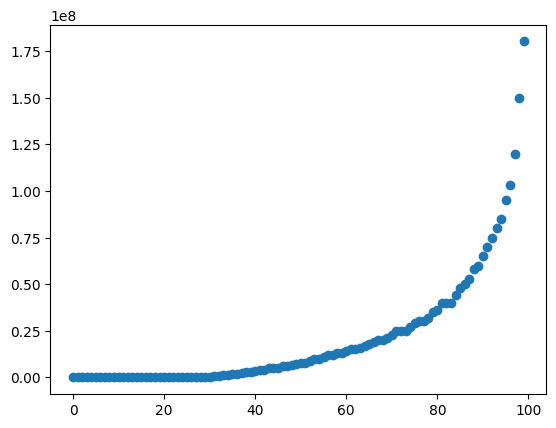

In [81]:
A = []
for i in range(0,100):
  A.append(np.percentile(movies['budget'], i))

plt.scatter(list(range(100)),A)

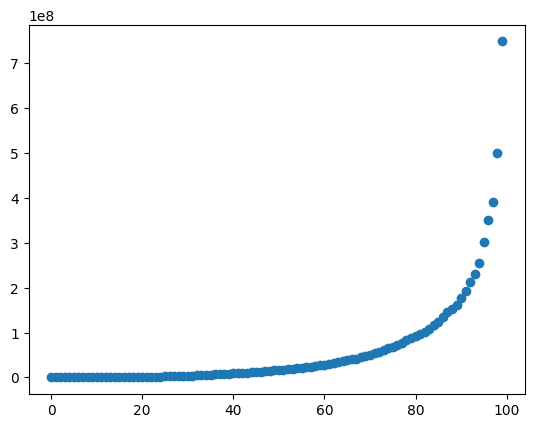

In [16]:
A = []
for i in range(0,100):
  A.append(np.percentile(movies['revenue'], i))

plt.scatter(list(range(100)),A)

Just for this experiment we will only conserve the 80% percentile

In [17]:
# movies = movies[movies['revenue']<np.percentile(movies['revenue'], 80)].reset_index(drop=True)

In [18]:
# A = []
# for i in range(0,100):
#   A.append(np.percentile(movies['budget'], i))

# plt.scatter(list(range(100)),A)

In [19]:
# A = []
# for i in range(0,100):
#   A.append(np.percentile(movies['revenue'], i))

# plt.scatter(list(range(100)),A)

In [115]:
engineered_movies = movies.copy()

In [21]:
engineered_movies.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [116]:
engineered_movies['genres'] = engineered_movies['genres'].fillna(engineered_movies['genres'].mode()[0])

def clean_genres(liste):
  return [re.findall("'name': '\w+'",liste)[j].split(' ')[1][1:-1] for j in range(len(re.findall("'name': '\w+'",liste)))]

engineered_movies['genres'] = [clean_genres(engineered_movies['genres'][i]) for i in range(len(engineered_movies['genres']))]
engineered_movies[engineered_movies['genres'].explode().unique()] = 0

for i in range(len(engineered_movies)):
  for genre in engineered_movies['genres'][i]:
    engineered_movies[genre][i] = 1

engineered_movies = engineered_movies.drop(columns=['genres','belongs_to_collection','id','poster_path','imdb_id','spoken_languages'])
del engineered_movies[engineered_movies.columns[-1]]
engineered_movies.head()

,budget,homepage,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,...,Horror,Documentary,Music,Crime,Mystery,Foreign,Fantasy,War,Western,History
0,14000000,NaN,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,...,0,0,0,0,0,0,0,0,0,0
1,40000000,NaN,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,...,0,0,0,0,0,0,0,0,0,0
2,3300000,http://sonyclassics.com/whiplash/,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,...,0,0,0,0,0,0,0,0,0,0
3,1200000,http://kahaanithefilm.com/,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,...,0,0,0,0,0,0,0,0,0,0
4,0,NaN,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,...,0,0,0,0,0,0,0,0,0,0


In [117]:
def clean_production_companies(liste):
  try:
    return [re.findall("'name': '.*',",
            liste.split('}, {')[j].replace('{','').replace('}','').replace('[','').replace(']',''))[0].split(": '")[1][:-2] 
            for j in range(len(liste.split('}, {')))]
  except:
    return ['Production Companies not there']

engineered_movies['production_companies'] = [clean_production_companies(engineered_movies['production_companies'][i]) for i in range(len(engineered_movies['production_companies']))]
engineered_movies[engineered_movies['production_companies'].explode().unique()] = 0

for i in range(len(engineered_movies)):
  for production_companie in engineered_movies['production_companies'][i]:
    engineered_movies[production_companie][i] = 1

engineered_movies.head()

,budget,homepage,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,...,Chris Lee Productions,Illusion Entertainment,Concorde Pictures,Abbas Kiarostami Productions,Island Pictures,Douglas Fairbanks Pictures,Loofah Productions,Tailor Made,Mango Farms,Quick Six Entertainment
0,14000000,NaN,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,"[Paramount Pictures, United Artists, Metro-Gol...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,...,0,0,0,0,0,0,0,0,0,0
1,40000000,NaN,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,[Walt Disney Pictures],"[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,...,0,0,0,0,0,0,0,0,0,0
2,3300000,http://sonyclassics.com/whiplash/,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,"[Bold Films, Blumhouse Productions, Right of W...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,...,0,0,0,0,0,0,0,0,0,0
3,1200000,http://kahaanithefilm.com/,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,[Production Companies not there],"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,...,0,0,0,0,0,0,0,0,0,0
4,0,NaN,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,[Production Companies not there],"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,...,0,0,0,0,0,0,0,0,0,0


In [118]:
engineered_movies = engineered_movies.drop(columns=['production_companies'])
engineered_movies.head()

,budget,homepage,original_language,original_title,overview,popularity,production_countries,release_date,runtime,status,...,Chris Lee Productions,Illusion Entertainment,Concorde Pictures,Abbas Kiarostami Productions,Island Pictures,Douglas Fairbanks Pictures,Loofah Productions,Tailor Made,Mango Farms,Quick Six Entertainment
0,14000000,NaN,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,Released,...,0,0,0,0,0,0,0,0,0,0
1,40000000,NaN,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,"[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,Released,...,0,0,0,0,0,0,0,0,0,0
2,3300000,http://sonyclassics.com/whiplash/,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,"[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,Released,...,0,0,0,0,0,0,0,0,0,0
3,1200000,http://kahaanithefilm.com/,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,Released,...,0,0,0,0,0,0,0,0,0,0
4,0,NaN,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,Released,...,0,0,0,0,0,0,0,0,0,0


In [119]:
def clean_production_countries(liste):
  try:
    return [re.findall("'iso_3166_1': '.*',",
            liste.split('}, {')[j].replace('{','').replace('}','').replace('[','').replace(']',''))[0].split(": '")[1][:-2] 
            for j in range(len(liste.split('}, {')))]
  except:
    return ['Production countries not there']

engineered_movies['production_countries'] = [clean_production_countries(engineered_movies['production_countries'][i]) for i in range(len(engineered_movies['production_countries']))]
engineered_movies[engineered_movies['production_countries'].explode().unique()] = 0

for i in range(len(engineered_movies)):
  for production_companie in engineered_movies['production_countries'][i]:
    engineered_movies[production_companie][i] = 1

engineered_movies.head()

,budget,homepage,original_language,original_title,overview,popularity,production_countries,release_date,runtime,status,...,SG,CY,UY,PY,MR,CR,BS,BF,GH,ID
0,14000000,NaN,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,[US],2/20/15,93.0,Released,...,0,0,0,0,0,0,0,0,0,0
1,40000000,NaN,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,[US],8/6/04,113.0,Released,...,0,0,0,0,0,0,0,0,0,0
2,3300000,http://sonyclassics.com/whiplash/,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,[US],10/10/14,105.0,Released,...,0,0,0,0,0,0,0,0,0,0
3,1200000,http://kahaanithefilm.com/,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,[IN],3/9/12,122.0,Released,...,0,0,0,0,0,0,0,0,0,0
4,0,NaN,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,[KR],2/5/09,118.0,Released,...,0,0,0,0,0,0,0,0,0,0


In [120]:
engineered_movies = engineered_movies.drop(columns=['production_countries'])
engineered_movies.head()

,budget,homepage,original_language,original_title,overview,popularity,release_date,runtime,status,tagline,...,SG,CY,UY,PY,MR,CR,BS,BF,GH,ID
0,14000000,NaN,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,2/20/15,93.0,Released,The Laws of Space and Time are About to be Vio...,...,0,0,0,0,0,0,0,0,0,0
1,40000000,NaN,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,8/6/04,113.0,Released,It can take a lifetime to find true love; she'...,...,0,0,0,0,0,0,0,0,0,0
2,3300000,http://sonyclassics.com/whiplash/,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,10/10/14,105.0,Released,The road to greatness can take you to the edge.,...,0,0,0,0,0,0,0,0,0,0
3,1200000,http://kahaanithefilm.com/,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,3/9/12,122.0,Released,NaN,...,0,0,0,0,0,0,0,0,0,0
4,0,NaN,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,2/5/09,118.0,Released,NaN,...,0,0,0,0,0,0,0,0,0,0


In [27]:
engineered_movies['overview'][0]

'When Lou, who has become the "father of the Internet," is shot by an unknown assailant, Jacob and Nick fire up the time machine again to save their friend.'

In [28]:
engineered_movies['tagline'][0]

'The Laws of Space and Time are About to be Violated.'

In [29]:
(engineered_movies['title'] == engineered_movies['original_title']).sum()

2649

In [121]:
# So we drop the column title because original_title has more values.
engineered_movies = engineered_movies.drop(columns=['title'])

In [31]:
engineered_movies.columns[0:14]

Index(['budget', 'homepage', 'original_language', 'original_title', 'overview',
       'popularity', 'release_date', 'runtime', 'status', 'tagline',
       'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

In [32]:
engineered_movies['Keywords'][2]

"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]"

# **Filling missing values**

Initially, it is imperative to address the issue of absent values. The dataset is plotted utilizing the Seaborn library, followed by imputation of missing data through assigning the median value to numerical data and the mode value to categorical features.

<Axes: >

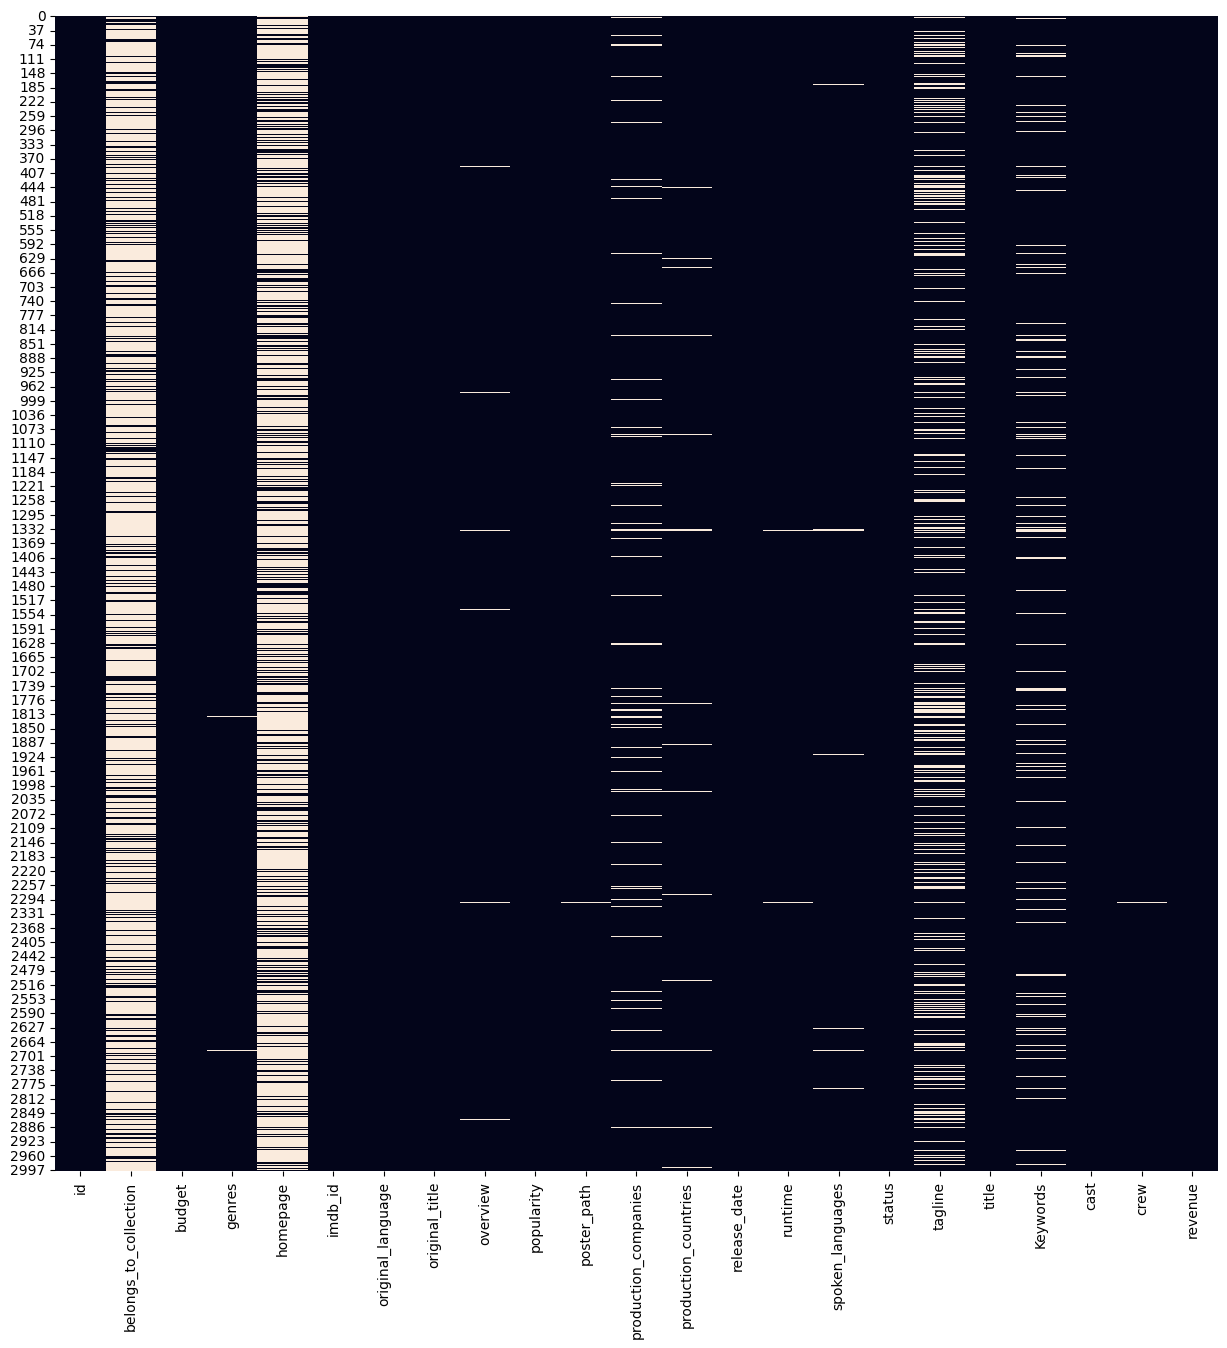

In [33]:
plt.figure(figsize=(15, 15))
sns.heatmap(movies.isnull(), cbar=False)

The strategy proposed to address the issue of incompleteness in the dataset involves the imputation of missing numeric variables through the calculation of the median, while the categorical column will be filled in using the mode. The remedy for the categorical missing values is scheduled to be dealt with subsequent to the completion of the feature engineering process on the remaining columns, which is anticipated to take place towards the conclusion of the overall procedure.

The selection of an appropriate approach for imputing missing values is not rigidly defined by scientific principles. Numerous practitioners experiment with various missing value imputation methods and subsequently determine the technique that attains the optimal evaluation score.

# **Decomposing Date**

Subsequently, the date column may be disassembled into its constituent attributes. It should be noted that the month and day are encoded as string variables due to the absence of a numeric relationship between the two. The temporal parameters of days and months are constrained, as the maximum value for months is 12 and days cannot exceed 31. Day 10 and Day 31 may be regarded as distinct categories, denoting dissimilar temporal occurrences.

The year, month, and day should be segregated into distinct columns within the dataframe.

In [122]:
engineered_movies['release_date'] = pd.to_datetime(engineered_movies['release_date'])
# Decomposition
engineered_movies['Year'] = engineered_movies['release_date'].dt.year
engineered_movies['Month'] = engineered_movies['release_date'].dt.month.astype(str)
engineered_movies['Day'] = engineered_movies['release_date'].dt.day.astype(str)
engineered_movies[['Year','Month','Day']].head()

,Year,Month,Day
0,2015,2,20
1,2004,8,6
2,2014,10,10
3,2012,3,9
4,2009,2,5


# **Adjusting budget**

To compensate for the substantial right-skewedness of the budget distribution, the natural logarithm of the budget is adopted as an adjustment measure. It is noteworthy that the logarithm of the budget + 1 is employed here as a considerable number of movies exhibit a budgetary allocation of $0, and it is practically impossible to compute the logarithm of 0.

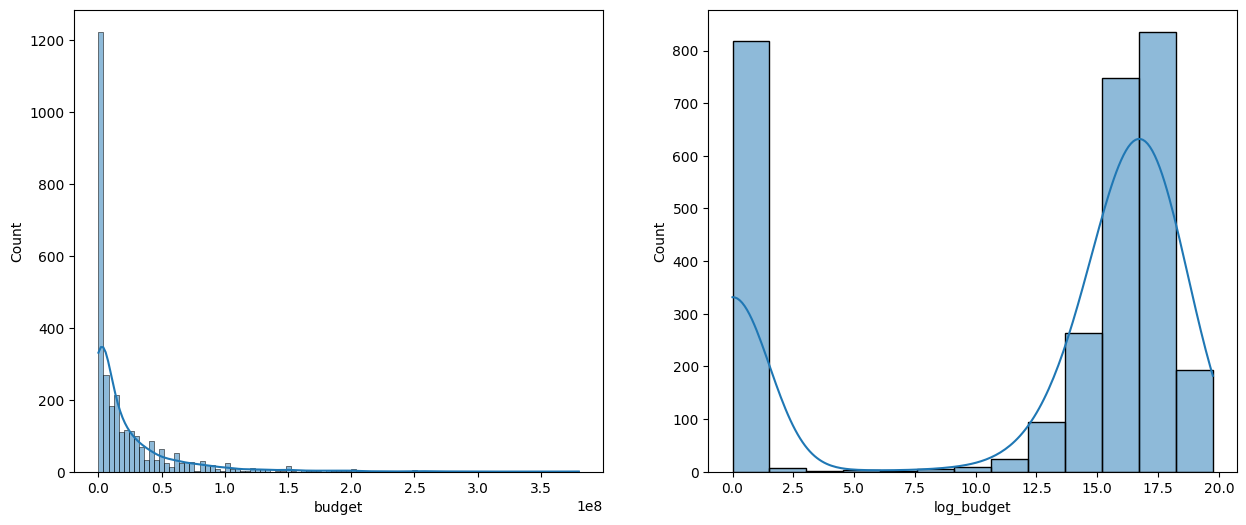

In [123]:
engineered_movies['log_budget'] = np.log(engineered_movies['budget'] + 1)
plot_hist(engineered_movies['budget'], engineered_movies['log_budget'])

# **Encoding inflation**

It is a well-established fact that the budget undergoes an annual increase, albeit to a certain degree, owing to inflationary factors. The encoding process may be achieved through the utilization of a basic inflation formula, which may be presented as:

inflation_budget = budget * (1 + (1.8 / 100) * (MaxYear - CurrentYear))


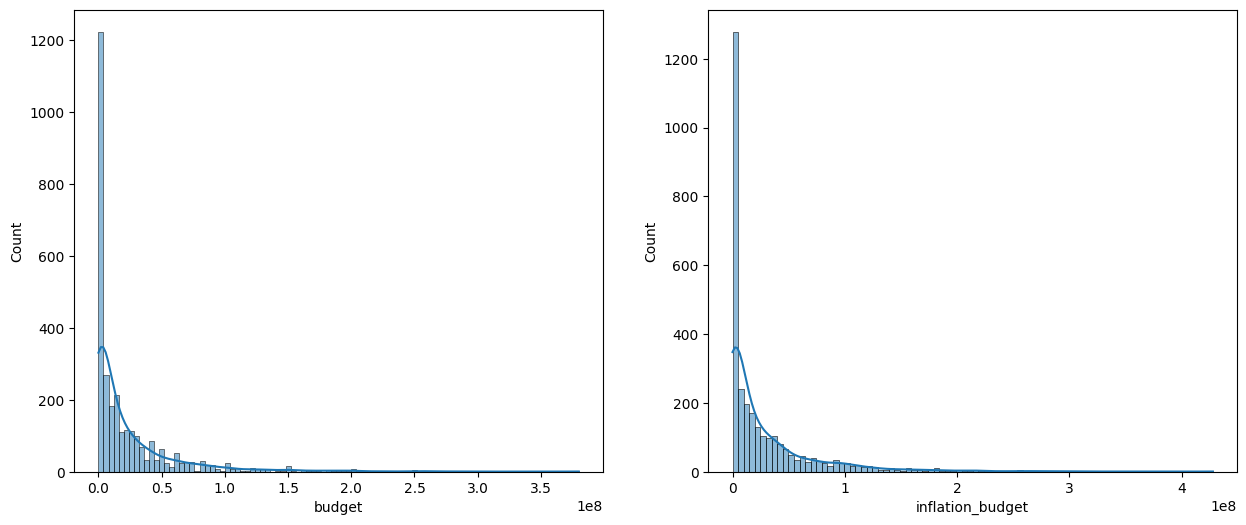

In [124]:
engineered_movies['inflation_budget'] = engineered_movies['budget'] * (1 + (1.8 / 100) * (2018 - engineered_movies['Year']))
plot_hist(engineered_movies['budget'], engineered_movies['inflation_budget'])

# **Other interesting features**

Drawing upon expertise in the relevant domain, it is possible to formulate a set of informative ratio variables in the following manner:

In [125]:
engineered_movies['budget_runtime_ratio'] = engineered_movies['budget'] / engineered_movies['runtime'] 
engineered_movies['budget_popularity_ratio'] = engineered_movies['budget'] / engineered_movies['popularity']
engineered_movies['budget_year_ratio'] = engineered_movies['budget'] / (engineered_movies['Year'] * engineered_movies['Year'])
engineered_movies['releaseYear_popularity_ratio'] = engineered_movies['Year'] / engineered_movies['popularity']

# **Indicator variables**

An indicator variable is utilized to encode the presence or absence of a homepage for a given movie, alongside an additional indicator variable indicating the language of the movie being in English.

In [126]:
# Has a homepage
engineered_movies['has_homepage'] = 1
engineered_movies.loc[pd.isnull(engineered_movies['homepage']), "has_homepage"] = 0 
# Was in English
engineered_movies['is_english'] = np.where(engineered_movies['original_language']=='en', 1, 0)
# And now we can fill in the missing categorical column values.
# Fill remaining columns - categorical columns - with mode
engineered_movies = engineered_movies.apply(lambda x: x.fillna(x.value_counts().index[0]))
# We subset the data frame to include only the variables we want.
# engineered_movies = movies[['budget_runtime_ratio', 'budget_popularity_ratio', 'budget_year_ratio', 'releaseYear_popularity_ratio', 'inflation_budget', 'Year',
#                     'Month', 'is_english', 'has_homepage', 'budget', 'popularity', 'runtime', 'revenue']]

The categorical columns are subjected to one-hot-encoding. In the present investigation, solely one categorical column exists, specifically the month column.

In [127]:
engineered_movies = engineered_movies.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
engineered_movies = pd.get_dummies(engineered_movies)
engineered_movies.head()

,budget,popularity,release_date,runtime,revenue,Comedy,Drama,Family,Romance,Thriller,...,Day_29,Day_3,Day_30,Day_31,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9
0,14000000,6.575393,2015-02-20,93.0,12314651,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,40000000,8.248895,2004-08-06,113.0,95149435,1,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
2,3300000,64.299990,2014-10-10,105.0,13092000,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200000,3.174936,2012-03-09,122.0,16000000,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,1.148070,2009-02-05,118.0,3923970,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


# **Now that our dataset is ready, we can go through the process of selecting useful features (feature selection) and make predictions.**

# **Prediction**

In order to demonstrate the efficacy of feature engineering and its consequential enhancement of the performance of the model, it is possible to construct a rudimentary regression model aimed at estimating the revenue generated by cinematic productions.

Typically, the selection of features is accomplished through a procedure known as feature selection. But we focus here on feature engineering,we shall focus of a fundamental process, viz. correlation analysis.

Through the plotting of the correlation matrix (provided below), it is evident that the majority of the features generated display a limited predictive capacity with respect to revenue. Frequently, a multitude of features are developed, yet a small subset ultimately proves to be functional; nevertheless, the consequential impact of these select features is significant.

The present analysis will incorporate the variables of has_homepage, budget_year_ratio, and is_english into the model, alongside the pre-existing features of budget, runtime, and popularity, thus depicted in the plot below.

In [40]:
# plt.figure(figsize=(10, 8))
# sns.heatmap(engineered_movies.corr())

We will use approximately 80% of the dataset for training the baseline and feature engineered models, and compare their performances on the hidden test set.

In [41]:
# train_engineered = engineered_movies[['budget','runtime','popularity', 'has_homepage','budget_year_ratio','is_english']].iloc[:2500]
# train_baseline = engineered_movies[['budget','runtime','popularity']].iloc[:2500]
# test_engineered = engineered_movies[['budget','runtime','popularity', 'has_homepage','budget_year_ratio','is_english']].iloc[2500:2750]
# test_baseline = engineered_movies[['budget','runtime','popularity']].iloc[2500:2750]
# valid_engineered = engineered_movies[['budget','runtime','popularity', 'has_homepage','budget_year_ratio','is_english']].iloc[2750:3001]
# valid_baseline = engineered_movies[['budget','runtime','popularity']].iloc[2750:3001]
# target_train = engineered_movies['revenue'].iloc[:2500]
# target_test = engineered_movies['revenue'].iloc[2500:2750]
# target_valid = engineered_movies['revenue'].iloc[2750:3001]

In [128]:
training_movies = movies.select_dtypes(include=np.number)
training_movies = training_movies.drop(columns='id').fillna(training_movies.median()[0])
training_engineered_movies= engineered_movies.select_dtypes(include=np.number)

In [129]:
training_engineered_movies

,budget,popularity,runtime,revenue,Comedy,Drama,Family,Romance,Thriller,Action,...,Day_29,Day_3,Day_30,Day_31,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9
0,14000000,6.575393,93.0,12314651,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,40000000,8.248895,113.0,95149435,1,1,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3300000,64.299990,105.0,13092000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200000,3.174936,122.0,16000000,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1.148070,118.0,3923970,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,9.853270,102.0,1596687,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2996,0,3.727996,102.0,180590,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2997,65000000,14.482345,120.0,89456761,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2998,42000000,15.725542,90.0,171963386,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# # pearson's correlation feature selection for numeric input and numeric output
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_regression

# # define feature selection
# fs = SelectKBest(score_func=f_regression, k=4)
# # apply feature selection
# training_engineered_movies_feature_selected = fs.fit_transform(training_engineered_movies.drop(columns='revenue'), training_movies['revenue'])
# print(training_engineered_movies_feature_selected.shape)

In [45]:
# from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
# poly_engineered = PolynomialFeatures(2)
# spline = SplineTransformer(degree=2, n_knots=3)
# training_engineered_movies_feature_selected = spline.fit_transform(poly_engineered.fit_transform(training_engineered_movies_feature_selected))

In [130]:
training_movies.head()

,budget,popularity,runtime,revenue
0,14000000,6.575393,93.0,12314651
1,40000000,8.248895,113.0,95149435
2,3300000,64.299990,105.0,13092000
3,1200000,3.174936,122.0,16000000
4,0,1.148070,118.0,3923970


In [131]:
training_movies.isna().sum()

budget        0
popularity    0
runtime       0
revenue       0
dtype: int64

In [132]:
target_train = training_movies['revenue'].iloc[:9*len(training_movies)//10]
target_test = training_movies['revenue'].iloc[9*len(training_movies)//10:]

training_engineered_movies = training_engineered_movies.drop(columns='revenue')
training_movies = training_movies.drop(columns='revenue')

train_engineered = training_engineered_movies[:9*len(training_movies)//10]
train_baseline = training_movies.iloc[:9*len(training_movies)//10]

test_engineered = training_engineered_movies[9*len(training_movies)//10:]
test_baseline = training_movies.iloc[9*len(training_movies)//10:]

In [133]:
pca = PCA(0.9999)
pca.fit(train_engineered)
PCA(copy=True, iterated_power='auto', n_components=0.9999, random_state=None, svd_solver='auto', tol=0.0, whiten=False)

PCA(n_components=0.9999)

In [134]:
pca.n_components_

4

In [135]:
train_engineered = pca.transform(train_engineered)
test_engineered = pca.transform(test_engineered)

In [136]:
from sklearn.metrics import mean_absolute_percentage_error
reg_baseline = LinearRegression().fit(train_baseline, target_train)
reg_predict_baseline = reg_baseline.predict(test_baseline)

reg_engineered = LinearRegression().fit(train_engineered, target_train)
reg_predict_engineered = reg_engineered.predict(test_engineered)

rmse_baseline = np.sqrt(mean_squared_error(target_test, reg_predict_baseline))
rmse_engineered = np.sqrt(mean_squared_error(target_test, reg_predict_engineered))
mape_baseline = mean_absolute_percentage_error(target_test, reg_predict_baseline)
mape_engineered = mean_absolute_percentage_error(target_test, reg_predict_engineered)
print('Baseline RMSE =', rmse_baseline)
print('Engineered RMSE =', rmse_engineered)
print('Baseline MAPE =', mape_baseline)
print('Engineered MAPE =', mape_engineered)
rmse_difference = rmse_baseline - rmse_engineered
mape_difference = mape_baseline - mape_engineered
print ("The difference in RMSE is", round(rmse_difference, 2), "dollars")
print ("The difference in mape is", round(mape_difference, 2))

Baseline RMSE = 81617067.88014458
Engineered RMSE = 81492334.39842138
Baseline MAPE = 3639.8893736247064
Engineered MAPE = 3296.1411572588245
The difference in RMSE is 124733.48 dollars
The difference in mape is 343.75


In [137]:
from sklearn import linear_model
reg_baseline = linear_model.Lasso().fit(train_baseline, target_train)
reg_predict_baseline = reg_baseline.predict(test_baseline)

reg_engineered = linear_model.Lasso().fit(train_engineered, target_train)
reg_predict_engineered = reg_engineered.predict(test_engineered)

rmse_baseline = np.sqrt(mean_squared_error(target_test, reg_predict_baseline))
rmse_engineered = np.sqrt(mean_squared_error(target_test, reg_predict_engineered))
mape_baseline = mean_absolute_percentage_error(target_test, reg_predict_baseline)
mape_engineered = mean_absolute_percentage_error(target_test, reg_predict_engineered)
print('Baseline RMSE =', rmse_baseline)
print('Engineered RMSE =', rmse_engineered)
print('Baseline MAPE =', mape_baseline)
print('Engineered MAPE =', mape_engineered)
rmse_difference = rmse_baseline - rmse_engineered
mape_difference = mape_baseline - mape_engineered
print ("The difference in RMSE is", round(rmse_difference, 2), "dollars")
print ("The difference in mape is", round(mape_difference, 2))

Baseline RMSE = 81617067.88506924
Engineered RMSE = 81492334.39842145
Baseline MAPE = 3639.8893558713935
Engineered MAPE = 3296.1411572588104
The difference in RMSE is 124733.49 dollars
The difference in mape is 343.75


In [138]:
from sklearn import linear_model
reg_baseline = linear_model.Ridge().fit(train_baseline, target_train)
reg_predict_baseline = reg_baseline.predict(test_baseline)

reg_engineered = linear_model.Ridge().fit(train_engineered, target_train)
reg_predict_engineered = reg_engineered.predict(test_engineered)

rmse_baseline = np.sqrt(mean_squared_error(target_test, reg_predict_baseline))
rmse_engineered = np.sqrt(mean_squared_error(target_test, reg_predict_engineered))
mape_baseline = mean_absolute_percentage_error(target_test, reg_predict_baseline)
mape_engineered = mean_absolute_percentage_error(target_test, reg_predict_engineered)
print('Baseline RMSE =', rmse_baseline)
print('Engineered RMSE =', rmse_engineered)
print('Baseline MAPE =', mape_baseline)
print('Engineered MAPE =', mape_engineered)
rmse_difference = rmse_baseline - rmse_engineered
mape_difference = mape_baseline - mape_engineered
print ("The difference in RMSE is", round(rmse_difference, 2), "dollars")
print ("The difference in mape is", round(mape_difference, 2))

Baseline RMSE = 81617071.6968168
Engineered RMSE = 81492334.39842139
Baseline MAPE = 3639.874572909705
Engineered MAPE = 3296.141157258819
The difference in RMSE is 124737.3 dollars
The difference in mape is 343.73


The contrast between the two models is distinct. The baseline model, which solely employs budget, runtime, and popularity as independent variables, generates projections that fall short, on average, by $124 737 compared to the model that incorporates our formulated features. Based on an assessment of the Root Mean Squared Error (RMSE) values derived from both models on the test set, it was determined that the aforementioned conclusion could be arrived at.

Utilizing feature engineering techniques enabled the model to acquire an enhanced comprehension of the underlying dataset and subsequently, the ability to generate improved predictions.

# **Now let's realize hyperparameters tuning and try other models:**

In [139]:
from sklearn.model_selection import GridSearchCV

params = {'alpha':[0.001,0.01,0.1,1,10,100],'fit_intercept':[True,False],'precompute':[True,False],'max_iter':[100,1000,5000],'warm_start':[True,False],'positive':[True,False],'selection':['cyclic','random']}

model1 = linear_model.Lasso()
grid_search_baseline = GridSearchCV(model1, params, cv=5, verbose=1, scoring='neg_root_mean_squared_error')

reg_baseline = grid_search_baseline.fit(train_baseline, target_train)
print('Best Hyperparameters: %s' % reg_baseline.best_params_)
reg_predict_baseline = reg_baseline.predict(test_baseline)

params_2 = {'alpha':[0.001,0.01,0.1,1,10,100],'fit_intercept':[True,False],'precompute':[True,False],'max_iter':[100,1000,5000],'warm_start':[True,False],'positive':[True,False],'selection':['cyclic','random']}

model2 = linear_model.Lasso()
grid_search_engineered = GridSearchCV(model1, params_2, cv=5, verbose=1, scoring='neg_root_mean_squared_error')
reg_engineered = grid_search_engineered.fit(train_engineered, target_train)
print('Best Hyperparameters: %s' % reg_engineered.best_params_)
reg_predict_engineered = reg_engineered.predict(test_engineered)

rmse_baseline = np.sqrt(mean_squared_error(target_test, reg_predict_baseline))
rmse_engineered = np.sqrt(mean_squared_error(target_test, reg_predict_engineered))
print('Baseline RMSE =', rmse_baseline)
print('Engineered RMSE =', rmse_engineered)
rmse_difference = rmse_baseline - rmse_engineered
print ("The difference in RMSE is", round(rmse_difference, 2), "dollars")

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best Hyperparameters: {'alpha': 100, 'fit_intercept': True, 'max_iter': 100, 'positive': True, 'precompute': False, 'selection': 'random', 'warm_start': False}
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best Hyperparameters: {'alpha': 100, 'fit_intercept': True, 'max_iter': 100, 'positive': True, 'precompute': False, 'selection': 'random', 'warm_start': True}
Baseline RMSE = 81616820.00002684
Engineered RMSE = 82272609.75482816
The difference in RMSE is -655789.75 dollars


In [140]:
params = {'num_leaves': [256], 'max_depth': [-1], 'learning_rate': [0.001], "bagging_seed": [16], "metric": ['rmse'], "verbosity": [-1],
          'lambda_l1': [0.001], 'lambda_l2': [0.001],'n_estimators':[20000],'linear_tree':[False],'max_bin':[255]}

model1 = lgb.LGBMRegressor(n_jobs = -1)
grid_search_baseline = GridSearchCV(model1, params, cv=2, verbose=1, scoring='neg_root_mean_squared_error')

reg_baseline = grid_search_baseline.fit(train_baseline, target_train, eval_metric='neg_root_mean_squared_error')
print('Best Hyperparameters: %s' % reg_baseline.best_params_)
reg_predict_baseline = reg_baseline.predict(test_baseline)

params_2 = {'num_leaves': [256], 'max_depth': [-1], 'learning_rate': [0.001], "bagging_seed": [32], "metric": ['rmse'], "verbosity": [-1],
          'lambda_l1': [0.001], 'lambda_l2': [0.001],'n_estimators':[20000],'linear_tree':[False],'max_bin':[255]}

model2 = lgb.LGBMRegressor(n_jobs = -1)
grid_search_engineered = GridSearchCV(model1, params_2, cv=2, verbose=1, scoring='neg_root_mean_squared_error')
reg_engineered = grid_search_engineered.fit(train_engineered, target_train, eval_metric='neg_root_mean_squared_error')
print('Best Hyperparameters: %s' % reg_engineered.best_params_)
reg_predict_engineered = reg_engineered.predict(test_engineered)

rmse_baseline = np.sqrt(mean_squared_error(target_test, reg_predict_baseline))
rmse_engineered = np.sqrt(mean_squared_error(target_test, reg_predict_engineered))
print('Baseline RMSE =', rmse_baseline)
print('Engineered RMSE =', rmse_engineered)
rmse_difference = rmse_baseline - rmse_engineered
print ("The difference in RMSE is", round(rmse_difference, 2), "dollars")

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
Best Hyperparameters: {'bagging_seed': 16, 'lambda_l1': 0.001, 'lambda_l2': 0.001, 'learning_rate': 0.001, 'linear_tree': False, 'max_bin': 255, 'max_depth': -1, 'metric': 'rmse', 'n_estimators': 20000, 'num_leaves': 256, 'verbosity': -1}
Fitting 2 folds for each of 1 candidates, totalling 2 fit

Difference of 2 466 614 dollars

In [57]:
# !pip install catboost

In [142]:
import catboost
params = {'langevin':True,'num_leaves': 128, 'max_depth': 4, "verbose": 100, 'n_estimators':200000,'grow_policy':'Lossguide',
          'l2_leaf_reg':1000, "model_size_reg": 0,'leaf_estimation_method':'Gradient',
          'leaf_estimation_iterations':50,'leaf_estimation_backtracking':'No','approx_on_full_history':False,
          'boosting_type':'Plain','boost_from_average':False,'diffusion_temperature':10000,'posterior_sampling':False,
          'score_function':'Cosine','penalties_coefficient':1,'bootstrap_type':'Poisson'}

model1 = catboost.CatBoostRegressor(**params, task_type="GPU")
model1.fit(train_baseline, target_train)
# grid_search_baseline = GridSearchCV(model1, params, cv=2, verbose=10, scoring='neg_root_mean_squared_error')
# reg_baseline = grid_search_baseline.fit(train_baseline, target_train, eval_set=[(valid_baseline, target_valid)])
# print('Best Hyperparameters: %s' % reg_baseline.best_params_)
reg_predict_baseline = model1.predict(test_baseline)

params_2 = {'langevin':True,'num_leaves': 256, 'max_depth': 12, "verbose": 100, 'n_estimators':20000,'grow_policy':'Lossguide',
          'l2_leaf_reg':100, "model_size_reg": 0,'leaf_estimation_method':'Gradient',
          'leaf_estimation_iterations':20,'leaf_estimation_backtracking':'No','approx_on_full_history':False, 
          'boosting_type':'Plain','boost_from_average':True,'diffusion_temperature':10000,'posterior_sampling':False, 
          'score_function':'Cosine','penalties_coefficient':1,'bootstrap_type':'Poisson','bagging_temperature':5,
          'subsample':0.8,'sampling_frequency':'PerTree','sampling_unit':'Object','random_strength':5,'min_data_in_leaf':200,
          'colsample_bylevel':1}

model2 = catboost.CatBoostRegressor(**params_2,task_type="GPU",early_stopping_rounds=300)
model2.fit(train_engineered, target_train)

# model2 = catboost.CatBoostRegressor(task_type="GPU",early_stopping_rounds=300)

# grid_search_engineered = GridSearchCV(model2, params_2, cv=2, verbose=100, scoring='neg_root_mean_squared_error')
# reg_engineered = grid_search_engineered.fit(train_engineered, target_train, eval_set=[(valid_engineered, target_valid)])

# reg_engineered = model2.fit(train_engineered, target_train, eval_set=[(valid_engineered, target_valid)])
# print('Best Hyperparameters: %s' % reg_engineered.best_params_)
reg_predict_engineered = model2.predict(test_engineered)

rmse_baseline = np.sqrt(mean_squared_error(target_test, reg_predict_baseline))
rmse_engineered = np.sqrt(mean_squared_error(target_test, reg_predict_engineered))
mape_baseline = mean_absolute_percentage_error(target_test, reg_predict_baseline)
mape_engineered = mean_absolute_percentage_error(target_test, reg_predict_engineered)
print('Baseline RMSE =', rmse_baseline)
print('Engineered RMSE =', rmse_engineered)
print('Baseline MAPE =', mape_baseline)
print('Engineered MAPE =', mape_engineered)
rmse_difference = rmse_baseline - rmse_engineered
mape_difference = mape_baseline - mape_engineered
print ("The difference in RMSE is", round(rmse_difference, 2), "dollars")
print ("The difference in mape is", round(mape_difference, 2))

0:	learn: 150088983.6434781	total: 17ms	remaining: 56m 32s
100:	learn: 77770834.4997014	total: 2.85s	remaining: 1h 34m 5s
200:	learn: 71651238.3838407	total: 7.34s	remaining: 2h 1m 34s
300:	learn: 68467763.2917397	total: 8.7s	remaining: 1h 36m 13s
400:	learn: 66163766.9331508	total: 10.1s	remaining: 1h 23m 41s
500:	learn: 64294542.9844415	total: 11.5s	remaining: 1h 16m 2s
600:	learn: 62791776.2139183	total: 12.8s	remaining: 1h 10m 47s
700:	learn: 61390384.5096291	total: 14.1s	remaining: 1h 7m 2s
800:	learn: 60135539.8734019	total: 15.5s	remaining: 1h 4m 23s
900:	learn: 59044450.8269886	total: 19s	remaining: 1h 9m 52s
1000:	learn: 57984978.1456849	total: 20.5s	remaining: 1h 7m 47s
1100:	learn: 57056953.3532203	total: 21.9s	remaining: 1h 5m 49s
1200:	learn: 56176659.3200689	total: 23.2s	remaining: 1h 4m 6s
1300:	learn: 55372459.9773723	total: 24.6s	remaining: 1h 2m 41s
1400:	learn: 54579715.4265253	total: 26s	remaining: 1h 1m 25s
1500:	learn: 53848311.1761917	total: 27.4s	remaining: 1h 1

Difference of $ 11 277 545

# **Conclusion**

**Feature Engineering Pitfalls**

Numerous potential pitfalls are associated with the practice of feature engineering, including but not limited to:

- Overfitting occurs when an excess of features are incorporated into a model, which poses a potential risk of fitting the data too closely. The phenomenon being elucidated is frequently denoted as the curse of dimensionality in scholarly discourse. In concurrence with the axioms of modelling, an increased feature set of a model corresponds to a heightened degree of flexibility in its capacity to establish finely tuned connections between the predictor and the target variable. Excessive flexibility in a model could potentially lead to overfitting, a phenomenon whereby the model becomes overly attuned to the particular training dataset it has encountered. Despite the apparent positive connotation of having a high degree of flexibility, this could have detrimental effects on the model's predictive accuracy when applied to novel datasets. This will induce a remarkable performance evaluation, nonetheless, it is prone to display poor performance on concealed or novel data due to the existence of divergences in the novel data, which were not perceived during the course of the training phase. The need for caution and prudence is crucial, with respect to out of sample testing, when scrutinizing features within the feature selection stage.

- Information leakage may occur as a consequence of inadequate feature engineering. Typically, this process encompasses the development of novel attributes employing the dependent variable. The process of feature engineering necessitates an independent treatment of the target variable and a singular focus on establishing meaningful predictor variables.

# **The feature engineering mindset**

The approach to feature engineering is highly exploratory in nature. Within modern society, quantitative factors are frequently prioritized above qualitative considerations. The consideration of quality is a crucial aspect when addressing the process of feature selection, which ensues subsequent to feature engineering. While there may be tentative indications of potentially beneficial characteristics, it is imperative to avoid succumbing to personal predisposition. It is instead advisable to generate the maximum number of pertinent traits feasible from the available data set, time and resources permitting, and complement this with a rigorous feature selection methodology to eliminate invalid features.